# Draftsheet 

In [ ]:
from fastcore.all import *
import wandb
from plotnine import *
import pandas as pd

### Get the validation errors of a classification learner, plot them in different ways and store the resulting images to be validated by an expert

In [ ]:
from PIL import Image  
import PIL
from fastcore.all import *

In [ ]:
def buffer_plot_and_get(fig):
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    return PIL.Image.open(buf)

In [ ]:
def get_concat_h_multi_resize(im_list, resample=PIL.Image.BICUBIC):
    min_height = min(im.height for im in im_list)
    im_list_resize = [im.resize((int(im.width * min_height / im.height), min_height),resample=resample)
                      for im in im_list]
    total_width = sum(im.width for im in im_list_resize)
    dst = PIL.Image.new('RGB', (total_width, min_height))
    pos_x = 0
    for im in im_list_resize:
        dst.paste(im, (pos_x, 0))
        pos_x += im.width
    return dst

In [ ]:
def get_multiview_at(ds, idx, ylim):
    "TODO: Move this to TensorMotion?"
    fig1 = show_at(ds, idx, return_fig=True, ylim=ylim)
    fig2 = show_at(ds, idx, return_fig=True)
    fig3 = show_at(ds, idx, mode='stacked', return_fig=True)
    pils = [buffer_plot_and_get(fig) for fig in [fig1, fig2, fig3]]
    return get_concat_h_multi_resize(pils)

In [ ]:
import pandas as pd

In [ ]:
def generate_classification_error_report(learn, folder, ylim):
    "Warning: Call this function with the %%capture magic, otherwise you will be \
    prompted with all the outputs from the calls to `show`. Requires xlrd to read xlsx \
    files."
    probs, targets, preds = learn.get_preds(with_decoded=True)
    error_valid_idxs = torch.where(targets!=preds, tensor(1), tensor(0)).nonzero().squeeze()
    error_ds_idxs = tensor(learn.dls.dataset.splits[1])[error_valid_idxs]
    for valid_idx, ds_idx in zip(error_valid_idxs, error_ds_idxs):
        merged_pil = get_multiview_at(learn.dls.valid.dataset, valid_idx, ylim)
        folder = Path(folder)
        merged_pil.save(f'{folder}/{ds_idx}.png')
    # Generate a csv file with the item indices and the targets
    preds_decoded = [str(ds.valid.tfms[1].decode(x)) for x in preds[error_valid_idxs]]
    targs_decoded = [str(ds.valid.tfms[1].decode(x)) for x in targets[error_valid_idxs]]
    rlbl_df = pd.DataFrame(list(zip(error_ds_idxs.numpy(), preds_decoded, targs_decoded)), 
                       columns=['Item #', 'ML classification', 'FLI-based classification'])
    rlbl_path = Path(f'{folder}/relabelling.xlsx')
    if rlbl_path.exists():
        # Load old relabelling and merge it with the new items
        rlbl_df_old = pd.read_excel(rlbl_path)
        rlbl_df = pd.concat([rlbl_df, rlbl_df_old]).drop_duplicates()
    rlbl_df = rlbl_df.sort_values(by=['Item #'])
    rlbl_df.to_excel(rlbl_path, index=False)

## Plot results from extrapolation experiment

In [ ]:
api = wandb.Api()

In [ ]:
sweep_paths = ["vrodriguezf/mlchaos/sweeps/lwatcf28", 
               "vrodriguezf/mlchaos/sweeps/29ewkxzx",
              "vrodriguezf/mlchaos/sweeps/xzwgf028"]
#sweep_paths = ["vrodriguezf/mlchaos/sweeps/obkusmv0", 
#               "vrodriguezf/mlchaos/sweeps/zbm7b79g",
#              "vrodriguezf/mlchaos/sweeps/pybesik5"]
runs = L([api.sweep(path=o).runs for o in sweep_paths]).concat()
runs

(#120) [<Run vrodriguezf/mlchaos/wrhnim2f (finished)>,<Run vrodriguezf/mlchaos/k851eo79 (finished)>,<Run vrodriguezf/mlchaos/428rajrb (finished)>,<Run vrodriguezf/mlchaos/aczwuabl (finished)>,<Run vrodriguezf/mlchaos/f991rqy5 (finished)>,<Run vrodriguezf/mlchaos/vvgfkctr (finished)>,<Run vrodriguezf/mlchaos/3vlv3aka (finished)>,<Run vrodriguezf/mlchaos/zafh6do4 (finished)>,<Run vrodriguezf/mlchaos/ju2armm4 (finished)>,<Run vrodriguezf/mlchaos/grlv7llo (finished)>...]

In [ ]:
df = pd.DataFrame({
    'Trained_on': runs.map(lambda o: o.config['train_model']), 
    'Tested_on': runs.map(lambda o: o.config['test_model']),
    'Test_eps': runs.map(lambda o: o.config['test_eps']),
    'Accuracy': runs.map(lambda o: o.summary.get('test_acc'))
})
df

,Trained_on,Tested_on,Test_eps,Accuracy
0,model_1,model_3,eps=0.025,0.714752
1,model_1,model_2,eps=0.025,0.703605
2,model_1,model_3,eps=0.02,0.748422
3,model_1,model_2,eps=0.02,0.760404
4,model_1,model_3,eps=0.015,0.794905
...,...,...,...,...
115,model_3,model_1,eps=0.02,0.975341
116,model_3,model_2,eps=0.015,0.950388
117,model_3,model_1,eps=0.015,0.983410
118,model_3,model_2,eps=0.01,0.922177


In [ ]:
df['Trained_on'] = np.select(
    [
        df['Trained_on'] == 'model_1', 
        df['Trained_on'] == 'model_2', 
        df['Trained_on'] == 'model_3'
    ],
    ['H2', 'H3', 'H4']
)
df['Tested_on'] = np.select(
    [
        df['Tested_on'] == 'model_1', 
        df['Tested_on'] == 'model_2', 
        df['Tested_on'] == 'model_3'
    ],
    ['H2', 'H3', 'H4']
)

Filter runs that have None Accuracy

In [ ]:
df = df.query('Accuracy == Accuracy')
df

,Trained_on,Tested_on,Test_eps,Accuracy
0,H2,H4,eps=0.025,0.714752
1,H2,H3,eps=0.025,0.703605
2,H2,H4,eps=0.02,0.748422
3,H2,H3,eps=0.02,0.760404
4,H2,H4,eps=0.015,0.794905
...,...,...,...,...
115,H4,H2,eps=0.02,0.975341
116,H4,H3,eps=0.015,0.950388
117,H4,H2,eps=0.015,0.983410
118,H4,H3,eps=0.01,0.922177


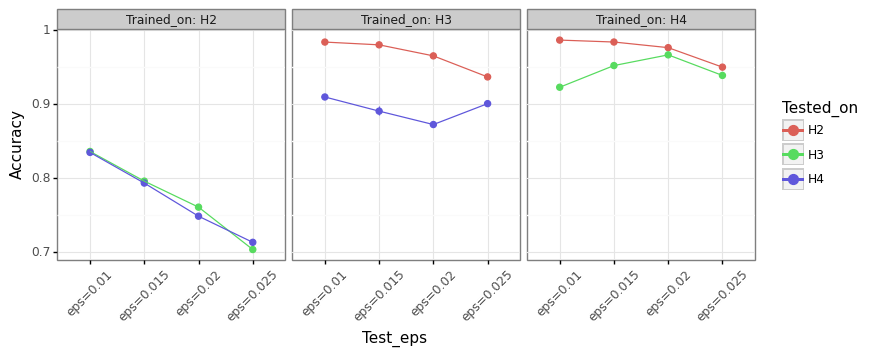

<ggplot: (8794382073869)>

In [ ]:
(
    ggplot(df, aes(x='Test_eps', y='Accuracy', color='Tested_on', group='Tested_on')) + 
    facet_wrap('~Trained_on', labeller='label_both') + 
    stat_summary(geom='geom_pointrange', shape='o') +
    stat_summary(geom='geom_line') + 
    theme_bw() +
    theme(axis_text_x=element_text(angle=45)) + 
    theme(figure_size=(9, 3))
)

### Plot accuracy vs points per motion

In [ ]:
df = pd.read_csv('../wandb_exports/wandb_export_2021-05-18T17_06_34.698+02_00.csv')

In [ ]:
df

,Name,input dim 2,_wandb,accuracy
0,solar-tree-180,2,NaN,0.753616
1,misty-butterfly-179,2,NaN,0.752755
2,charmed-sponge-178,2,NaN,0.750517
3,comic-serenity-177,2,NaN,0.831784
4,brisk-cloud-176,2,NaN,0.751722
...,...,...,...,...
145,floral-music-35,201,NaN,0.994835
146,helpful-pyramid-34,201,NaN,0.995351
147,gentle-wave-33,201,NaN,0.995007
148,dutiful-durian-32,201,NaN,0.995696


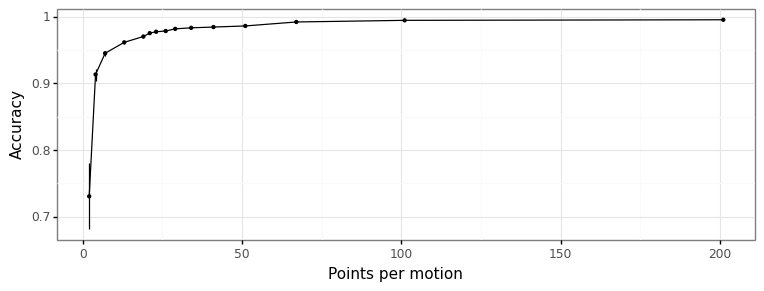

<ggplot: (8755227661650)>

In [ ]:
(
    ggplot(df, aes(x='input dim 2', y='accuracy', group=1)) + 
    stat_summary(geom='geom_pointrange', shape='.') +
    stat_summary(geom='geom_line') + 
    theme_bw() +
    xlab('Points per motion') +
    ylab('Accuracy') + 
    theme(figure_size=(9, 3))
)